## DESeq2 in python - pydeseq2

Nowadays, it is becoming more clear the fundamental role of flexibility between programming languages in bioinformatics analysis. In fact, there are new packages that allow to call functions written in one scripting language from another language. One of the most know package is [rpy2](https://rpy.sourceforge.io/rpy2/doc-dev/html/overview.html) which allows to use R function and call R object directly in a Python environment. These packages are of major importance because they allow the users to reuse existing code and perform analysis integrating different scripting languages.

The bioinformatics community is growing and evolving day by day searching for new solutions that guarantee reproducibility, scalability and flexibility. A huge amount of bioinformatics tools developed in past are written in R language. However, in the last few years, python is emerged as a new promising languages for bioinformatics analysis, since it reduces the time and resources of the analysis. One of the most used bioinformatics packages for the NGS analysis (including RNA-seq, ChIP-seq, ATAC-seq, Hi-C etc) is [DESeq2](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-014-0550-8). This package is part of the [Bioconductor project](https://www.bioconductor.org/) and it’s written in R language.

Here I created an example of the DESeq2 analysis integrating R with python through rpy2 package.

The toy dataset, the methods and plots are a reimplementation of [“Analyzing RNA-seq data with DESeq2”](https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#countmat)

The script was run on [JupyterHub]( https://jupyter.org/hub) using a [conda]( https://docs.conda.io/en/latest/) environment(see below to have further information). Conda v4.5.11.

The aims of this work are:
* Generate a reproducible conda environment to run DESeq2 in Python 
* Create a tutorial for DESeq2 analysis in Python using rpy2 package. This tutorial has been tested on RNA-seq and ATAC-seq data.
* Replicate the analysis reported in DESeq2 [vignette]( https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html)
* Reimplement DESeq2 canonical plots in python using [Matplotlib](https://matplotlib.org/) and [Seaborn](https://seaborn.pydata.org/)
* Create a mini-package to run all the commands

### Create conda environment


Here we will use conda to create an environment for this script. The requirements and specific versions to successfully run this script are listed below. 

In [1]:
# # Create a new conda environment
# git clone https://github.com/FedeGerva/pydeseq2
# conda create --name pyDESeq2_env --file ~/pydeseq2/conda_env/conda_requirements.txt

# #Open conda env
# conda activate pyDESeq2_env

# pip install -r ~/pydeseq2/conda_env/1.4.2/pip_requirements.txt #impo rpy2 > 3.2.5 (see https://github.com/rpy2/rpy2/issues/631)

# #install pydeseq2 package
# pip install -e ~/pydeseq2

# R --vanilla <<code
# chooseCRANmirror(graphics=FALSE, ind=88) #Italy GARR

# if (!requireNamespace("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")
    
# BiocManager::install("GenomeInfoDbData") #version 1.2.2
# BiocManager::install("pasilla") #version 1.14.0
# BiocManager::install("vsn") #version 3.54.0
# code

# ipython kernel install --user --name pyDESeq2_env --display-name "pyDESeq2_env"

### Import Python and R packages

The first step is to import all the packages and libraries that we need to work with Python and R. Below you can see two chunks, one to import python packages and rpy2 package, the second one to import all the R packages and library. To use rpy2/R you need to import first rpy2 packages and then all the R libraries. To import R vectors and functions you can use the [R object package](https://rpy.sourceforge.io/rpy2/doc-dev/html/robjects.html#module-rpy2.robjects), please notice that “.” is syntactically valid for R objects but not for python’s. For this reason, “.” of R function are substituted with “_”. The following library are the one essential to run the script, keep in consideration the possibility to add more.


#### Import python modules

In [1]:
# from numpy.random import multinomial, random
import numpy as np
from numpy import *
from matplotlib.ticker import FuncFormatter
from matplotlib import collections  as mc
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
import pandas as pd
import os.path
import os

##if you're on JupyterHub you may need to specify the path to R - do it before import any rpy2 modules
jupiter_dir="/jupyterminiconda3" #name of the directory in which conda is saved
from pathlib import Path
home = str(Path.home())
os.environ['R_HOME']=os.path.join(home + jupiter_dir + "/envs/pyDESeq2_env/lib/R/")

##Import rpy2
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri
robjects.numpy2ri.activate()
%load_ext rpy2.ipython
from rpy2.robjects.packages import importr
from rpy2.robjects import Formula

##Import pydeseq2 package
import pydeseq2

/mnt/home/gervasoni/jupyterminiconda3/envs/pyDESeq2_env/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


#### Import R packages

In [2]:
##Import R packages
deseq = importr('DESeq2') #import deseq2
pasilla = importr('pasilla') #import pasilla
vsn = importr('vsn') #import vsn

##Import R functions
assay = robjects.r['assay']
assays=robjects.r['assays']
coef=robjects.r['coef']
colData=robjects.r['colData']
colnames=robjects.r['colnames']
counts=robjects.r['counts']
dispersions=robjects.r['dispersions']
mcols=robjects.r['mcols']
metadata = robjects.r['metadata']
names=robjects.r['names']
normTransform=robjects.r['normTransform']
rownames=robjects.r['rownames']
sign = robjects.r['sign']
sizeFactors=robjects.r['sizeFactors']
system_file = robjects.r['system.file']
substr=robjects.r['substr']
summary = robjects.r['summary']

In [3]:
##Initialize/setting working directory
wd=os.path.join(home, "demo_pyDESeq2")  #declare working dir
os.chdir(wd) #set working directory

### Set options

The following chunks are made to set all the visualization options that you want to add. I also create a dictionary with the annotation variable and colours to apply in each plot.

In [4]:
##Display df option
display_max_rows=pd.get_option('display.max_rows')
display_max_columns=pd.get_option('display.max_columns')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', display_max_rows)
pd.set_option('display.max_columns', display_max_columns)
##Plot options
plt.style.use('default')
sns.set_style("white")

In [5]:
##Create a dict with all the condition and the colors that you want to use - you will need to choose the colors and attributes to include inside the dict
TCcmap={'untreated:single-read': '#66c2a5','untreated:paired-end': '#fc8d62', 'treated:single-read':'#8da0cb', 'treated:paired-end':'#e78ac3', #pca
        'treated': '#9a009a','untreated': '#009900', 
        'single-read':'#110AEA','paired-end':'#cc0000',
       } 

### Import count matrix and samples information

The toy dataset chosen to run this tutorial is the count data from [Pasilla](http://bioconductor.org/packages/release/data/experiment/html/pasilla.html) package since it was the one chose by DESeq2 tutorial, making it easier to compare and follow.

In [6]:
##definition of functions to import objects. These functions are not in the package to be more flexible
def importCts(pathCts):
    """imort count matrix as pandas df"""
    cts=pd.read_table(pathCts[0], sep="\t", header=0, index_col=0, dtype="str")
    cts=cts.apply(pd.to_numeric)
    return cts

def importColdata(pathColdata, pathCts):
    """imort sample annotation as pandas df"""
    coldata=pd.read_csv(pathColdata[0],index_col=0) #import coldata information
    coldata.index=coldata.index.str.replace(r'fb$', '')
    coldata=coldata.loc[importCts(pathCts).columns]
    return coldata

In [7]:
cts=importCts(system_file("extdata", "pasilla_gene_counts.tsv", package="pasilla", mustWork=True))
coldata=importColdata(system_file("extdata", "pasilla_sample_annotation.csv", package="pasilla", mustWork=True), system_file("extdata", "pasilla_gene_counts.tsv", package="pasilla", mustWork=True))

In [8]:
##Print head of the count table
pd.DataFrame(cts).head()

,untreated1,untreated2,untreated3,untreated4,treated1,treated2,treated3
gene_id,,,,,,,
FBgn0000003,0,0,0,0,0,0,1
FBgn0000008,92,161,76,70,140,88,70
FBgn0000014,5,1,0,0,4,0,0
FBgn0000015,0,2,1,2,1,0,0
FBgn0000017,4664,8714,3564,3150,6205,3072,3334


In [9]:
pd.DataFrame(coldata)

,condition,type,number of lanes,total number of reads,exon counts
untreated1,untreated,single-read,2,17812866,14924838
untreated2,untreated,single-read,6,34284521,20764558
untreated3,untreated,paired-end,2,10542625 (x2),10283129
untreated4,untreated,paired-end,2,12214974 (x2),11653031
treated1,treated,single-read,5,35158667,15679615
treated2,treated,paired-end,2,12242535 (x2),15620018
treated3,treated,paired-end,2,12443664 (x2),12733865


In [10]:
coldata.index=coldata.index.str.replace(r'fb$', '') #remove fb to have the same names in coldata and cts

coldata=coldata.loc[cts.columns] #reorder coldata according to cts order

coldata.index.equals(cts.columns) #check that the order and names are the same

True

In [11]:
##set name of the experiment
name='pyDESeq2_demo'

##set design formula
condition = Formula("~condition")
# sampleinfo.head()

##set name to save rds files
file_dds = os.path.join(wd, "dds_"+ name+".rds")
file_rld = os.path.join(wd, "rld_"+ name+ ".rds")
file_vsd = os.path.join(wd, "vst_"+ name+ ".rds")

In [12]:
##Pre-filtering - not mandatory
keep=np.sum(cts,axis=1) >= 10
cts=cts[keep]

In [13]:
##convert cts and coldata from pandas to r dataframe - you can also pass numpy array and skip this process
r_cts, r_coldata=pydeseq2.pyConvertPandas(cts, coldata)

### Create or load dds/rld/vsd files

In the next session, the ` dds `, ` rld `, ` vsd ` are created if they don’t exist otherwise are simply loaded. To create these objects, we need to prepare the count table(`cts`) and ` coldata` in the proper format and to set the design formula.

In [14]:
dds=pydeseq2.pyDESeqDataSetFromMatrix(r_cts, r_coldata, design=condition)
rld=pydeseq2.pyrlogTransformation(dds)
vsd=pydeseq2.pyrVarStabTionformation(dds)

dds exists and it will be loaded
rld exists and it will be loaded
vsd exists and it will be loaded


In [15]:
print(dds)

class: DESeqDataSet 
dim: 9921 7 
metadata(1): version
assays(4): counts mu H cooks
rownames(9921): FBgn0000008 FBgn0000014 ... FBgn0261574 FBgn0261575
rowData names(22): baseMean baseVar ... deviance maxCooks
colnames(7): untreated1 untreated2 ... treated2 treated3
colData names(6): condition type ... exon.counts sizeFactor



### Size factor estimation

The size factor is calculated using _sizeFactors_ function of DESeq2 and the correlation between size factor and library size is shown in the associated plot.

In [16]:
print('size factors: ')
print(sizeFactors(dds))

size factors: 
untreated1 untreated2 untreated3 untreated4   treated1   treated2   treated3 
 1.1383376  1.7935406  0.6494828  0.7516005  1.6355014  0.7612159  0.8326603 



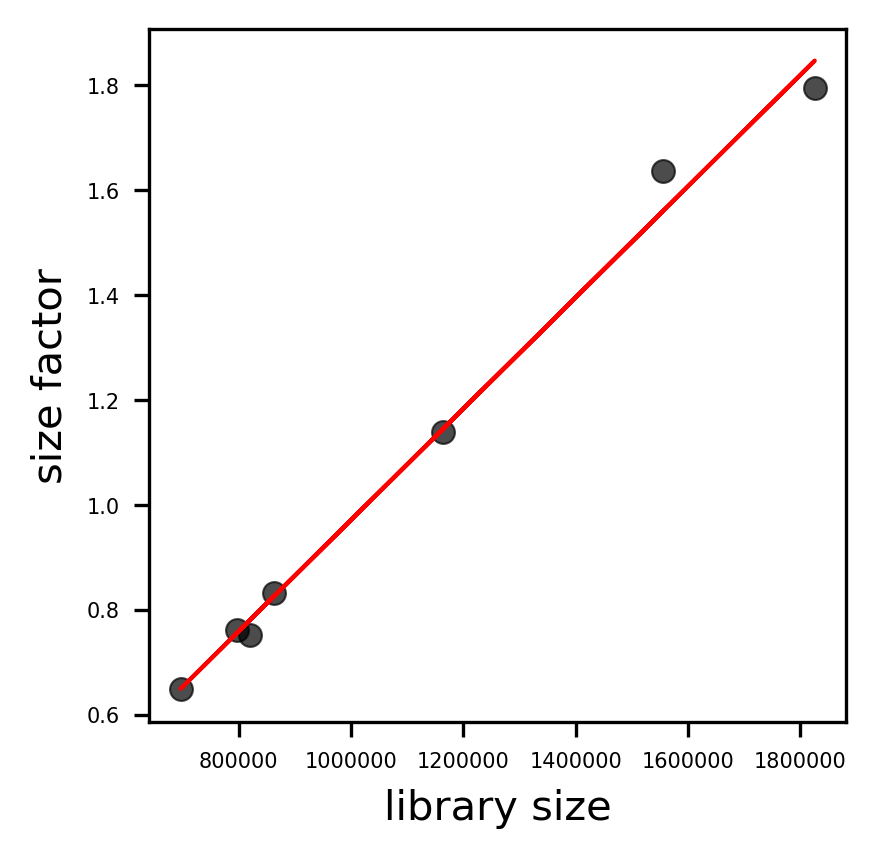

In [17]:
#Create df with libsize info and annotation
libSize_df=pydeseq2.pyCreateLibSizedf(dds, coldata=coldata)

#Plot
pydeseq2.pyPlotLibSizeFact(libSize_df, save='libsize.png')

### Dispersion plot and fitting alternatives

The _plotDispEsts_ and _pymeanSdPlot_ applied using rpy2 automatically generate and save the plot. For this reason, the plot is saved as png and it is shown in the notebook using the module display of IPhyton function.

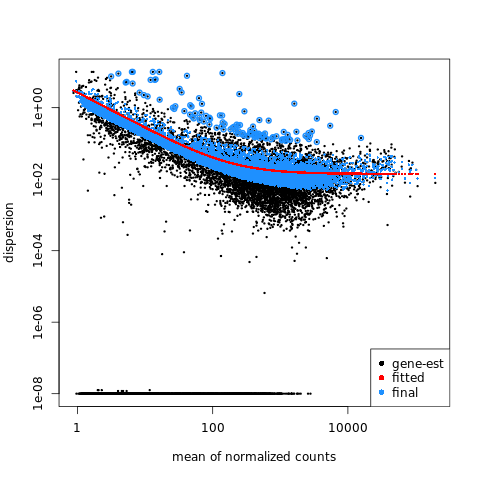

In [18]:
pydeseq2.pyPlotDispEsts(dds, wd=wd)

### Effects of transformations on the variance

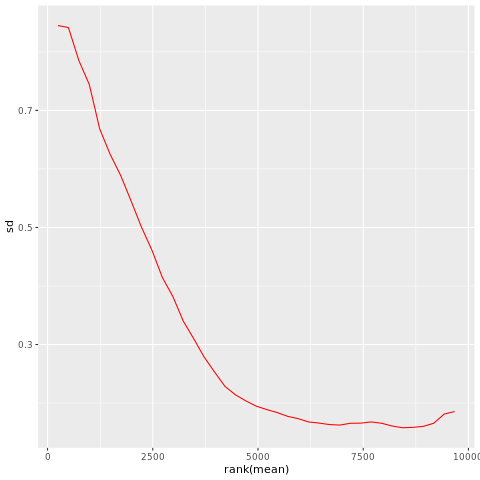

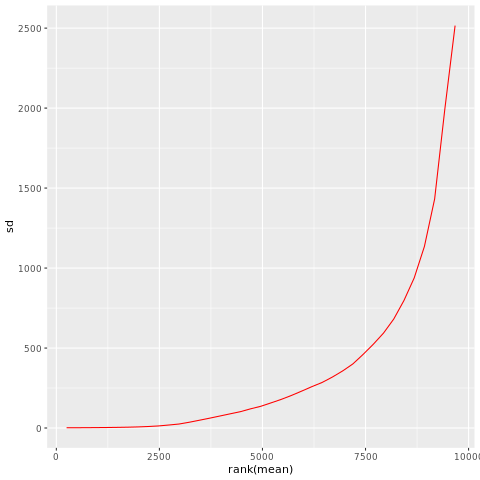

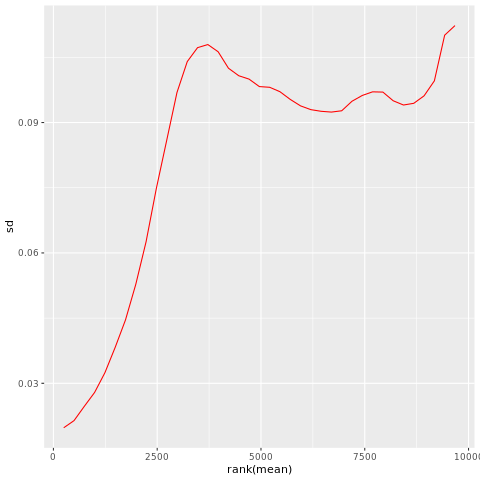

In [19]:
##this gives log2(n + 1)
ntd=normTransform(dds)
ntd_df=pd.DataFrame(np.matrix(assay(ntd)), index=rownames(dds), columns=colnames(dds))

dds_obj=[ntd, dds, rld]

for i in dds_obj:
    pydeseq2.pymeanSdPlot(i, wd=wd)

### PCA plot and Clusterin

PCA and clustering plot are made combining R and python functions. 

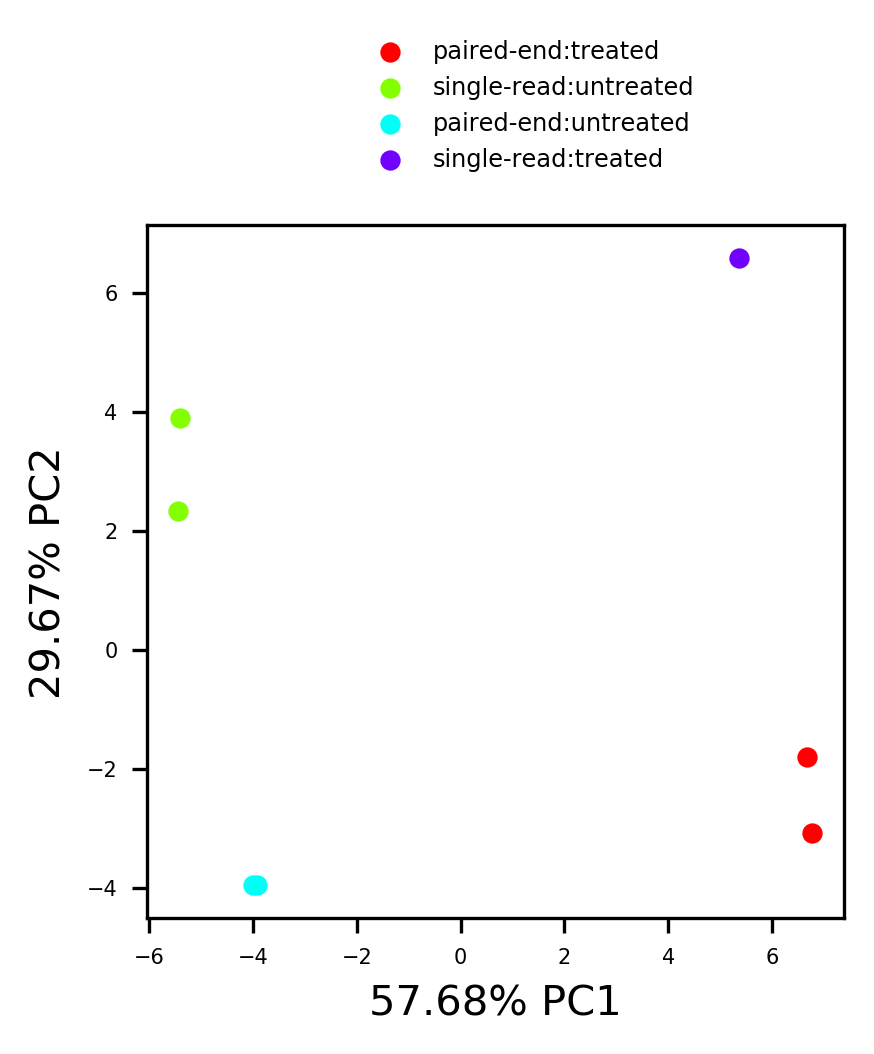

In [20]:
pydeseq2.pyPlotPCA(rld, intgroup_name=['type', 'condition'])

### Clustering

/mnt/home/gervasoni/jupyterminiconda3/envs/pyDESeq2_env/lib/python3.8/site-packages/seaborn/matrix.py:594: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


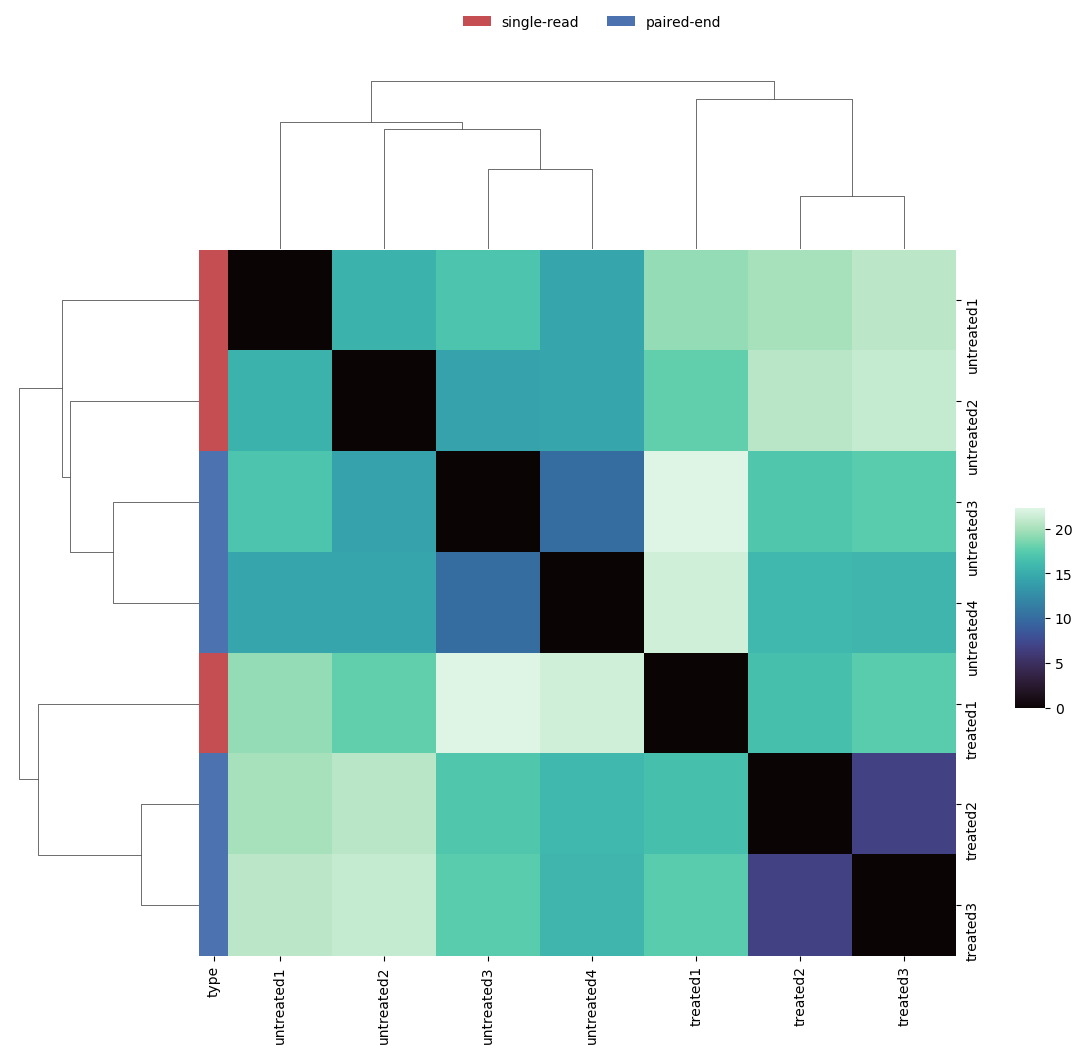

In [21]:
pydeseq2.pyPlotClustering(rld, coldata, intgroup_name=['type'] )

### Differential analysis

The analysis is executed as described in the reference manual. The contrast must be passed as np.array. The following plots were produced extracting the data and re implementing the plot in python.

In [22]:
##Inspect the comparison already present
print(deseq.resultsNames(dds))

[1] "Intercept"                      "condition_untreated_vs_treated"



In [23]:
contrast=np.array(['condition','treated', 'untreated']) #set the constrast

res, res_df=pydeseq2.pyresults(dds, contrast=contrast, alpha=0.1, save=True)

In [24]:
print(res) #print the res table

log2 fold change (MLE): condition treated vs untreated 
Wald test p-value: condition treated vs untreated 
DataFrame with 9921 rows and 6 columns
                    baseMean     log2FoldChange             lfcSE
                   <numeric>          <numeric>         <numeric>
FBgn0000008 95.1442917575889 0.0022761108805198  0.22372865100602
FBgn0000014 1.05652281859341 -0.495120756545263  2.14318392499052
FBgn0000017 4352.55356876647 -0.239919135875559 0.126336905174172
FBgn0000018  418.61048415965  -0.10467410323443 0.148489059549638
FBgn0000024   6.406199980976  0.210846502190346 0.689587530221461
...                      ...                ...               ...
FBgn0261570 3208.38861003698  0.295532700164221 0.127350479038669
FBgn0261572 6.19718814545467 -0.958824381105177 0.775314581832093
FBgn0261573 2240.97951122377 0.0127192990510504  0.11329997578873
FBgn0261574 4857.68037348332 0.0153919621581197 0.192567169446341
FBgn0261575 10.6825203335563  0.163567583258598 0.930910532966

In [25]:
res_df['padjxFC']=round(-np.log10(res_df['padj'])*np.sign(res_df['log2FoldChange']), 3) #add column with the padj * sign of log2FC - not mandatory
res_df.head()

/mnt/home/gervasoni/jupyterminiconda3/envs/pyDESeq2_env/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,padjxFC
FBgn0000008,95.144292,0.002276,0.223729,0.010174,0.991883,0.997209,0.001
FBgn0000014,1.056523,-0.495121,2.143184,-0.231021,0.817298,NaN,NaN
FBgn0000017,4352.553569,-0.239919,0.126337,-1.899042,0.057559,0.288001,-0.541
FBgn0000018,418.610484,-0.104674,0.148489,-0.704928,0.480855,0.826835,-0.083
FBgn0000024,6.406200,0.210847,0.689588,0.305757,0.759789,0.943502,0.025


In [26]:
##Extract results
n_padj=0.1 #set padj treshold

print(res_df.sort_values('padj', ascending=True).head())

print()

print('summary of the res:')
summary(res)

print()

print('Total number of differential interval')
print(res_df[res_df['padj'] <= n_padj].dropna().count()[1])

                baseMean  log2FoldChange     lfcSE       stat         pvalue  \
FBgn0039155   730.567673       -4.618742  0.169124 -27.309803  3.244375e-164   
FBgn0025111  1501.447930        2.899946  0.127358  22.770110  9.071904e-115   
FBgn0029167  3706.024008       -2.196912  0.097915 -22.436845  1.720260e-111   
FBgn0003360  4342.832062       -3.179541  0.143568 -22.146633  1.124133e-108   
FBgn0035085   638.219336       -2.560242  0.137813 -18.577711   4.868344e-77   

                      padj  padjxFC  
FBgn0039155  2.719111e-160 -159.566  
FBgn0025111  3.801581e-111  110.420  
FBgn0029167  4.805832e-108 -107.318  
FBgn0003360  2.355340e-105 -104.628  
FBgn0035085   8.160318e-74  -73.088  

summary of the res:

out of 9921 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 518, 5.2%
LFC < 0 (down)     : 536, 5.4%
outliers [1]       : 1, 0.01%
low counts [2]     : 1539, 16%
(mean count < 6)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentF

/mnt/home/gervasoni/jupyterminiconda3/envs/pyDESeq2_env/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


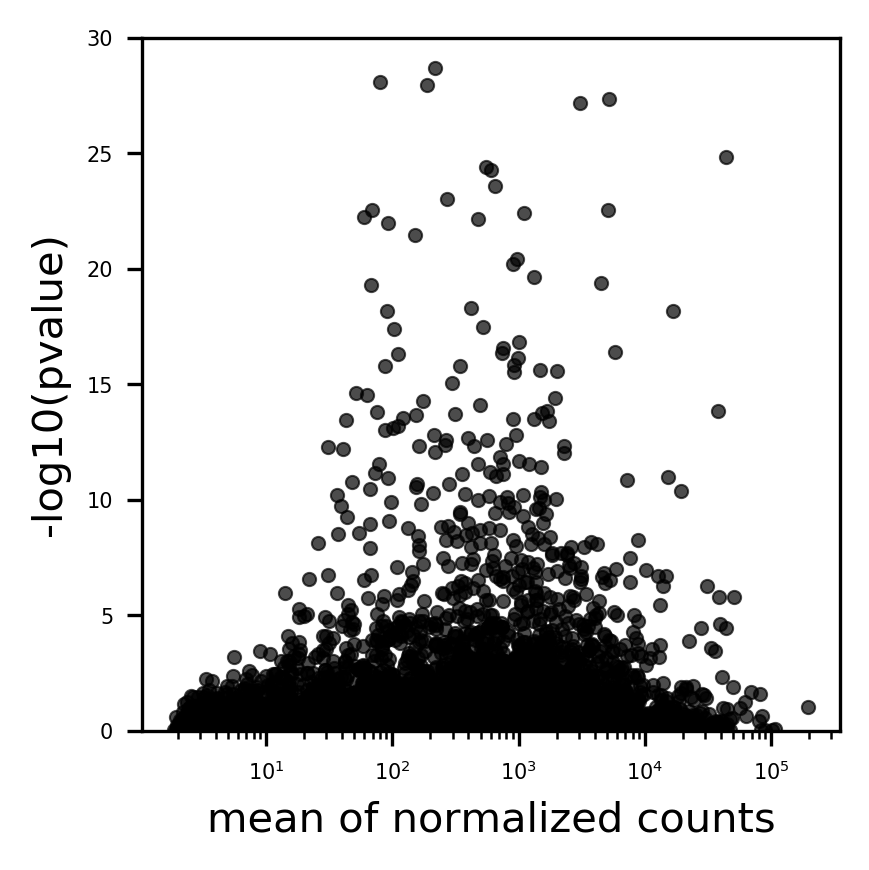

In [27]:
pydeseq2.pyPlotMeannormCount_lg10pval(res_df)

### Metadata

In [28]:
##Metadata - alpha set
print('alpha: ')
print(metadata(res)[4])

##Percentage of genes set to NA
##BaseMean threshold of genes set to NA 
print('filterThreshold: ')
print(metadata(res)[0])

alpha: 
[1] 0.1

filterThreshold: 
15.5102% 
6.150425 



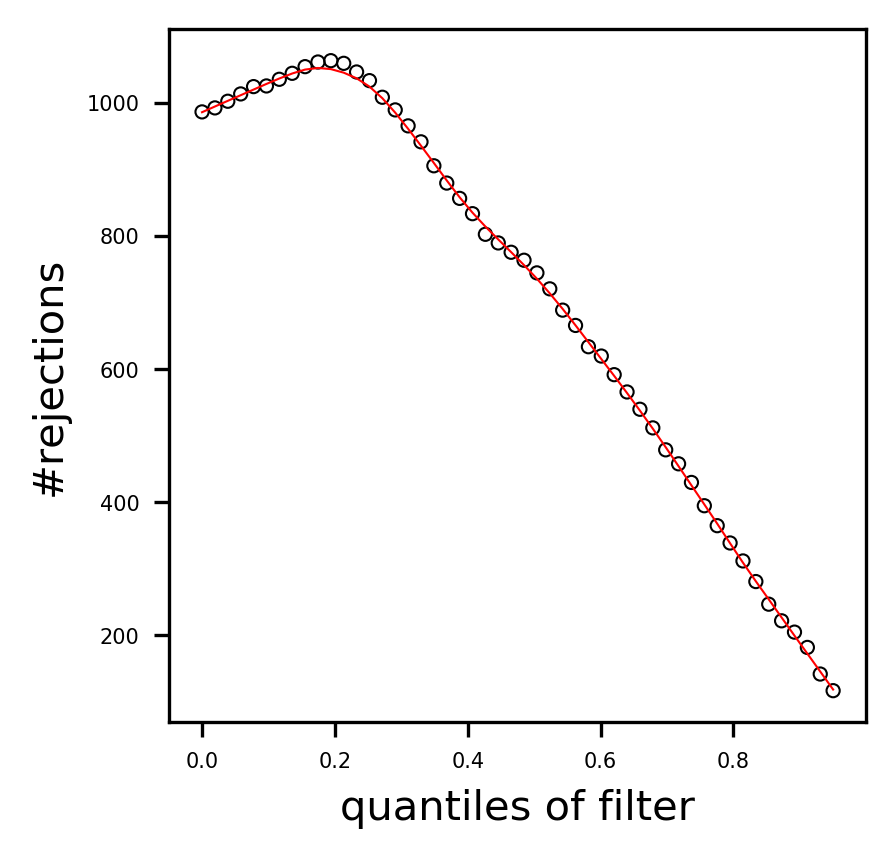

In [29]:
pydeseq2.pyPlotFilterNumRej(res)

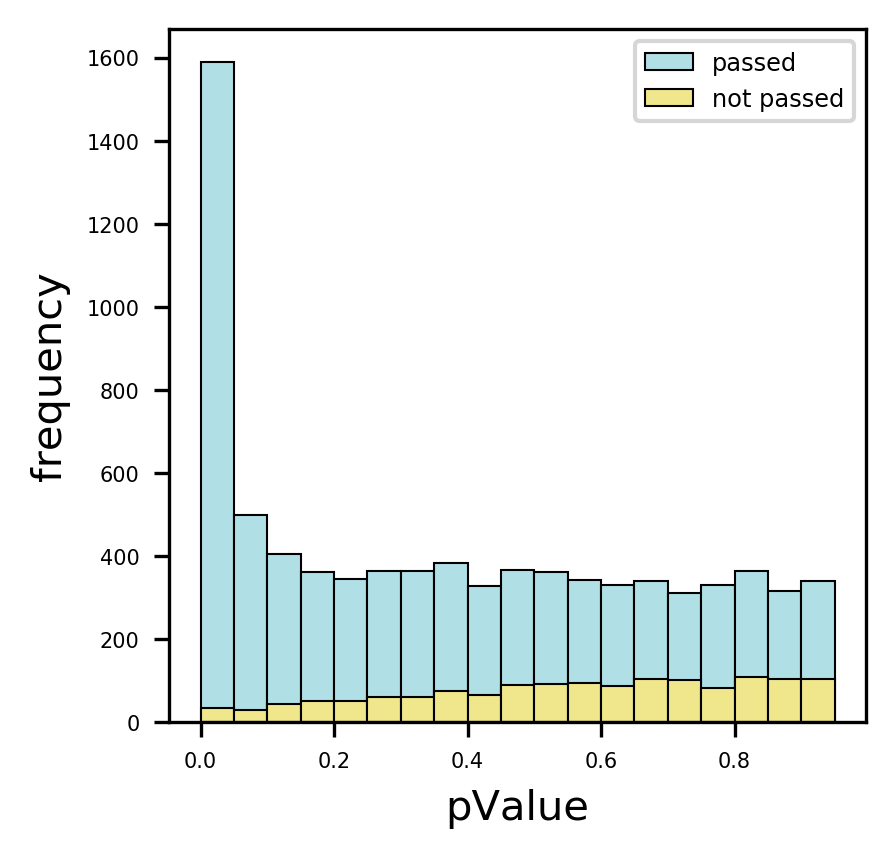

In [30]:
pydeseq2.pyPlotHistpvalue(res, res_df)

### MAplot

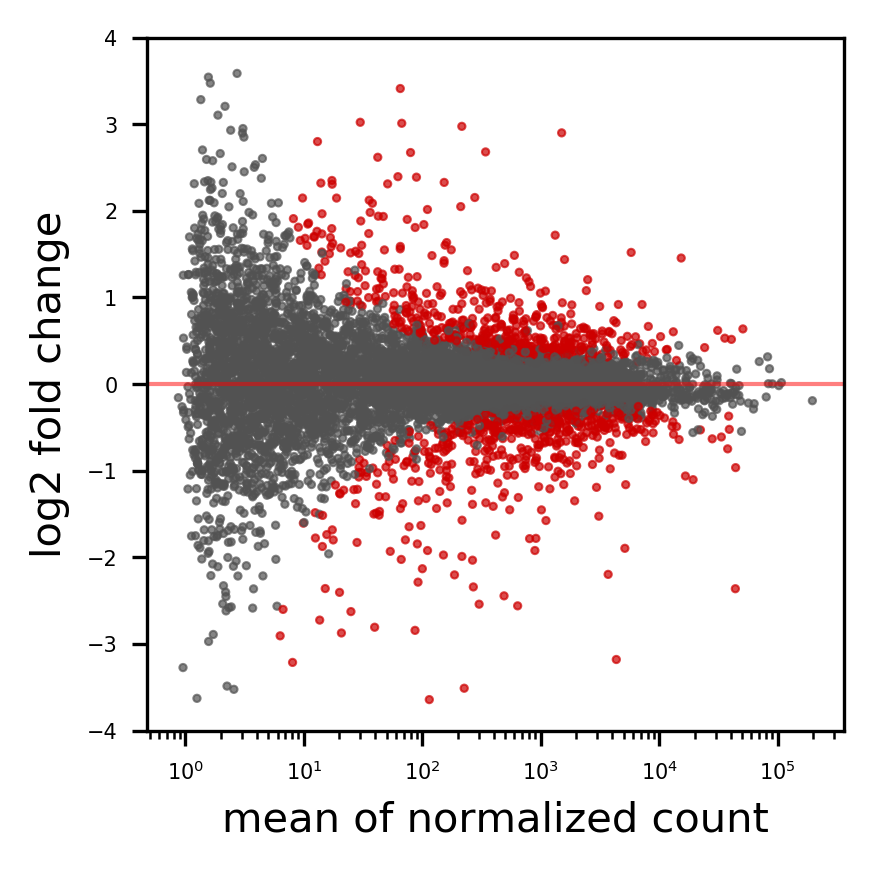

In [31]:
pydeseq2.pyPlotMA(res_df, n_padj=0.1, ylim=4)

### Volcano plot

/mnt/home/gervasoni/jupyterminiconda3/envs/pyDESeq2_env/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


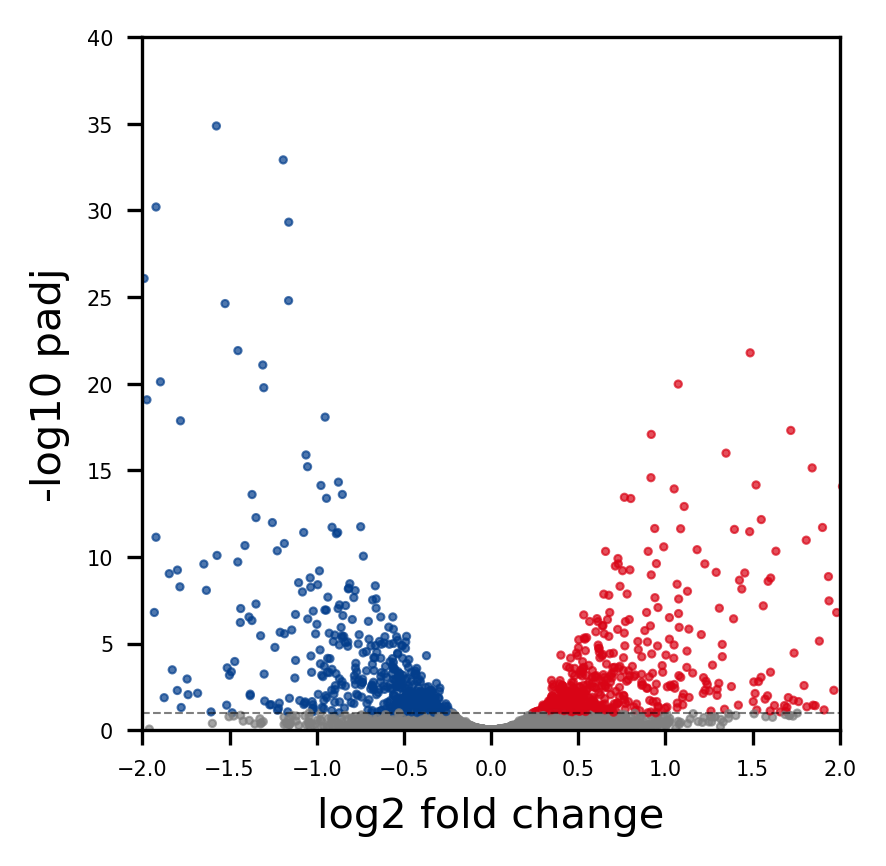

In [59]:
pydeseq2.pyPlotVolcano(res_df,  n_padj=0.1, ylim_max=40, xlim=2)

In [47]:
n_log2FC=0

##Retrive number of gene/interval using the treshold set for the vulcano plot
diff_up=res_df[(res_df['log2FoldChange'] >= n_log2FC) & (res_df['padj'] <= n_padj)]
print('#of differentially upregulated')
print(shape(diff_up)[0])

diff_down=res_df[(res_df['log2FoldChange'] <= -n_log2FC) & (res_df['padj'] <= n_padj)]
print('#of differentially downregulated')
print(shape(diff_down)[0])

#of differentially upregulated
518
#of differentially downregulated
536


### Boxplot of differentially upregulated/downregulated of genes-intervals - normalized counts

In [55]:
norm_filt_melt[['gene_id','variable', 'value','condition', 'type']]

,gene_id,variable,value,condition,type
0,FBgn0000043,untreated1,29342.789556,untreated,single-read
1,FBgn0000064,untreated1,6820.472370,untreated,single-read
2,FBgn0000071,untreated1,72.034870,untreated,single-read
3,FBgn0000116,untreated1,410.247372,untreated,single-read
4,FBgn0000146,untreated1,1416.978611,untreated,single-read
...,...,...,...,...,...
3621,FBgn0261362,treated3,8452.426073,treated,paired-end
3622,FBgn0261444,treated3,937.957483,treated,paired-end
3623,FBgn0261555,treated3,90.072742,treated,paired-end
3624,FBgn0261561,treated3,92.474681,treated,paired-end


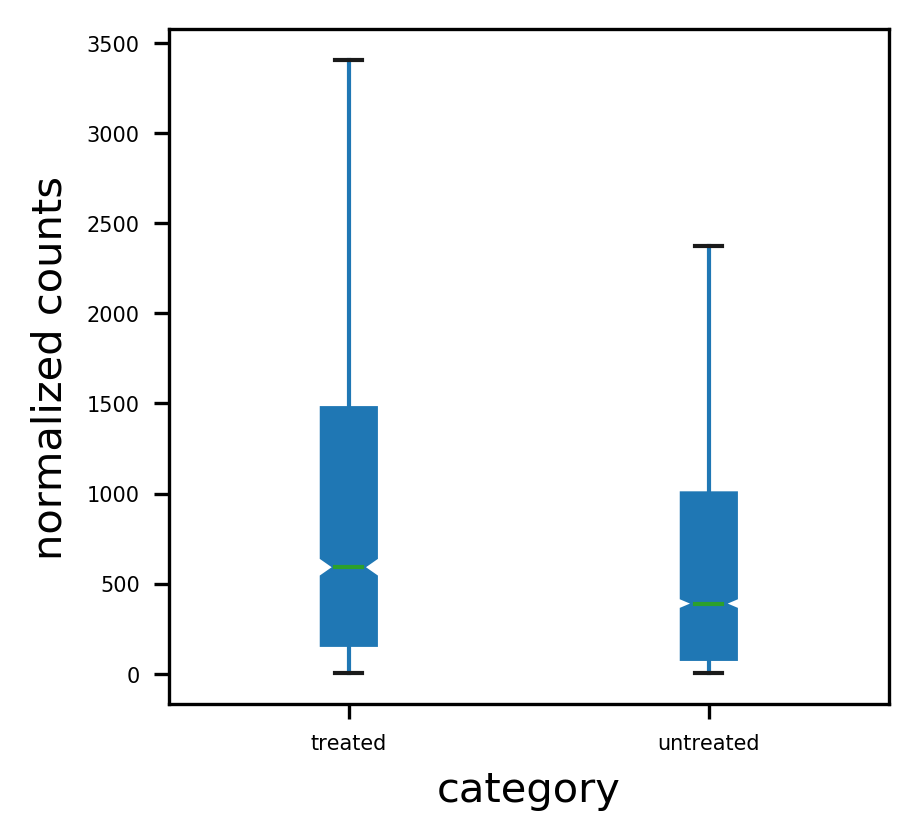

In [57]:
norm_count=counts(dds, normalized=True) #extract normalized count matrix 
norm_count=pd.DataFrame(np.matrix(norm_count), index=rownames(dds), columns=colnames(dds))

norm_filt=norm_count.loc[diff_up.index,] #names of the interval 2keep - if you want to have downregulated you just need to change de variable
col2keep=norm_filt.columns #names of the samples

norm_filt['gene_id']=norm_filt.index
norm_filt_melt=pd.melt(norm_filt, id_vars='gene_id', value_vars=col2keep)
coldata['variable']=coldata.index
norm_filt_melt=pd.merge(norm_filt_melt, coldata,  on='variable')

fig, (boxPlot_counts) = plt.subplots(1,1,figsize=(3, 3),dpi=300)

##plot
norm_filt_melt[['value','condition']].boxplot(by=['condition'], ax=boxPlot_counts, grid=False, notch=True, showfliers=False, patch_artist=True)

##axis
boxPlot_counts.set_title('')
boxPlot_counts.get_figure().suptitle("")
boxPlot_counts.set_xlabel('category', size=10)
boxPlot_counts.set_ylabel('normalized counts', size=10)
boxPlot_counts.tick_params(axis='both', which='major', labelsize=5)

### Boxplot of differentially upregulated/downregulated of genes-intervals - mean of normalized count

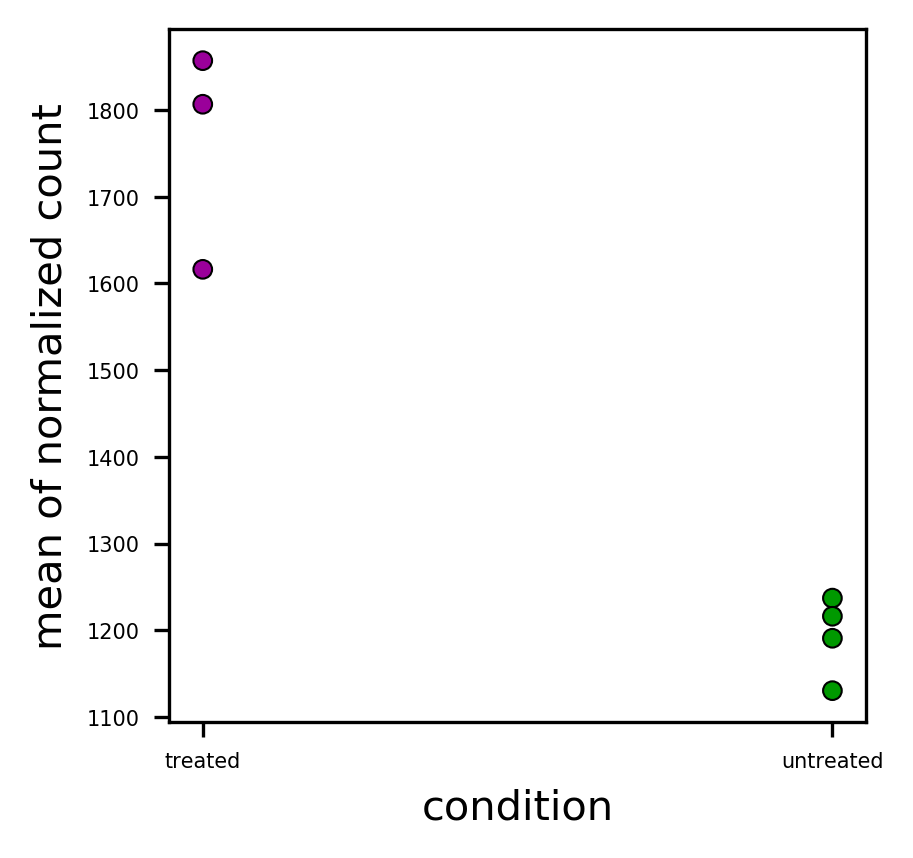

In [35]:
norm_filt_melt_mean=norm_filt_melt.groupby(['variable', 'condition'], as_index=False)['value'].mean()

fig, (scatter_meanNorm) = plt.subplots(1,1,figsize=(3, 3),dpi=300)

##plot
scatter_meanNorm.scatter(norm_filt_melt_mean.condition, norm_filt_melt_mean['value'], s=20, facecolors='none', 
                         edgecolors='black', linewidth=0.5, c=[TCcmap.get(x,"No_key") for x in norm_filt_melt_mean['condition']])

##axis
scatter_meanNorm.set_xlabel('condition', size=10)
scatter_meanNorm.set_ylabel('mean of normalized count', size=10)
scatter_meanNorm.tick_params(axis='both', which='major', labelsize=5)

### Heatmap of the count matrix

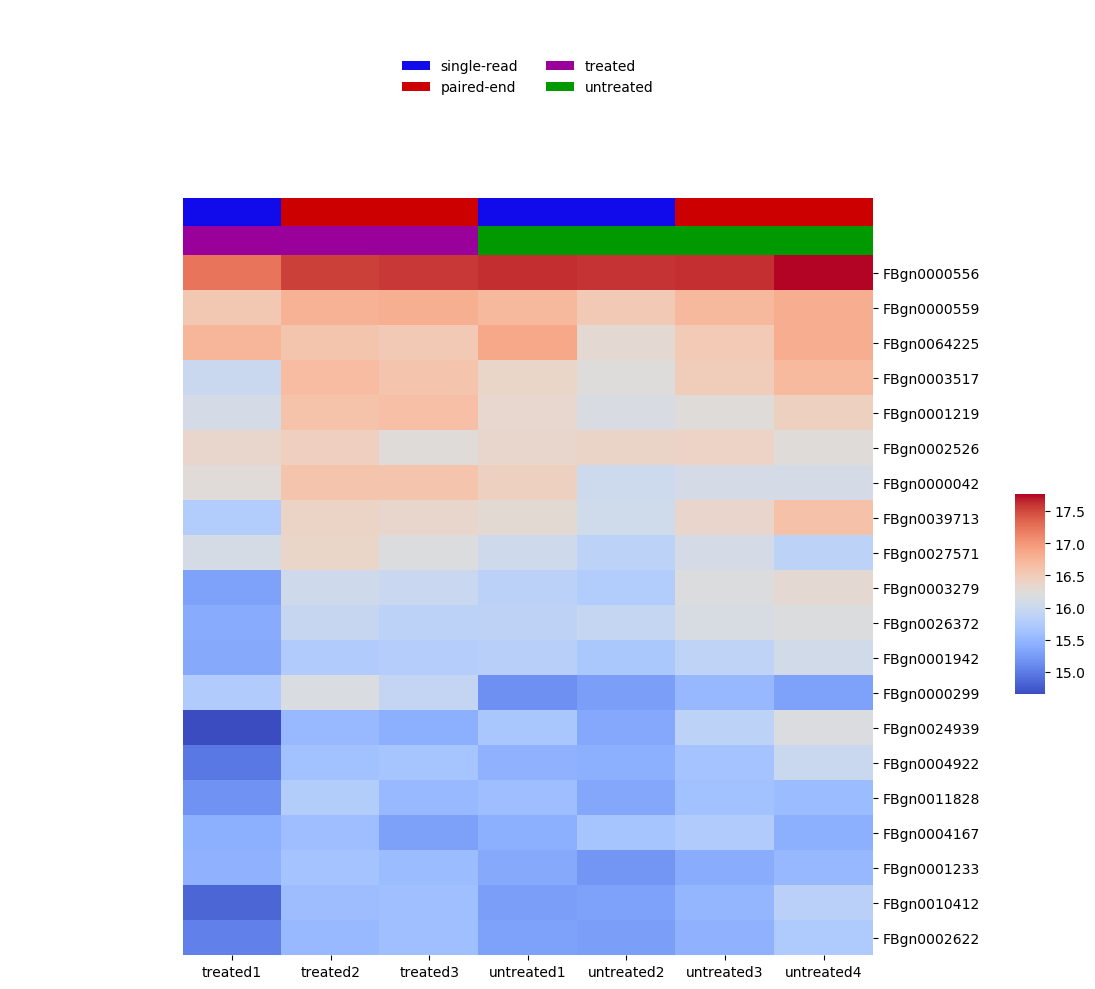

In [36]:
select=norm_count.mean(axis=1).sort_values(ascending=False)[0:20].index.to_numpy() ##select genes for the heatmap
col_ord= ['treated1','treated2','treated3', 'untreated1','untreated2','untreated3','untreated4'] ##columns order
ntd_df_sel=ntd_df.loc[select][col_ord] ##select row and reorder columns

##plot
g=sns.clustermap(ntd_df_sel, row_cluster=False, col_cluster=False, col_colors=[[TCcmap.get(x,"No_key") for x in coldata.reindex(np.array(ntd_df_sel.columns))['type']],
                 [TCcmap.get(x,"No_key") for x in coldata.reindex(np.array(ntd_df_sel.columns))['condition']]], 
                 cmap='coolwarm', yticklabels=True, xticklabels=True, linewidth=0, annot_kws={"size": 10})

##axis
for label in coldata.reindex(np.array(ntd_df_sel.columns))['type'].unique():
    g.ax_col_dendrogram.bar(0, 0, color=TCcmap[label],
                            label=label, linewidth=0)
    
for label in coldata.reindex(np.array(ntd_df_sel.columns))['condition'].unique():
    g.ax_col_dendrogram.bar(0, 0, color=TCcmap[label],
                            label=label, linewidth=0)

g.ax_col_dendrogram.legend(loc="upper center", ncol=2, bbox_to_anchor=(0.5, 0.8), frameon=False) ##legend label position
g.cax.set_position([1.02, .30, .03, .2]) ##colorbar position

### Other Plots

#### Denisty plot normalized count

(0, 10000)

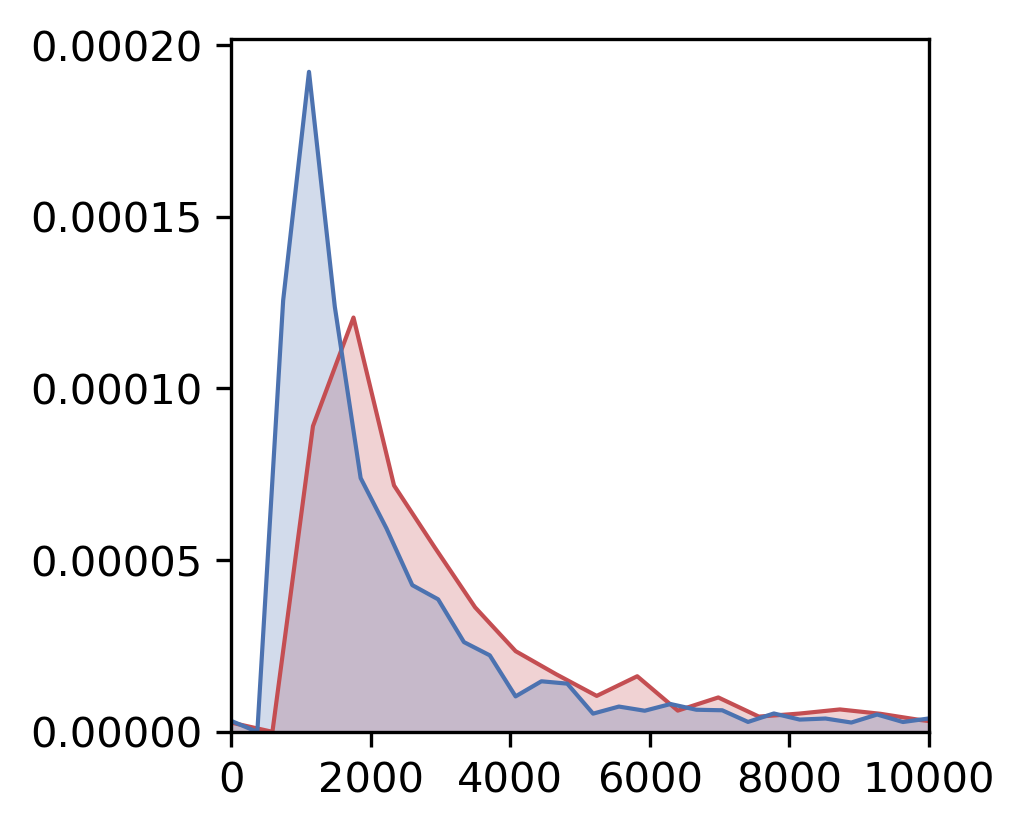

In [37]:
fig, (dens_norm) = plt.subplots(1,1,figsize=(3, 3),dpi=300)

sns.kdeplot(norm_filt_melt.loc[norm_filt_melt['condition']=='treated',]['value'].values, shade=True, color="r", ax=dens_norm, linewidth=1, cut=0)
sns.kdeplot(norm_filt_melt.loc[norm_filt_melt['condition']=='untreated',]['value'].values, shade=True, color="b", ax=dens_norm, linewidth=1, cut=0)
dens_norm.set_xlim(0, 10000)

### Investigate the dds

In [38]:
tuple(assays(dds).slotnames())

('listData', 'elementType', 'elementMetadata', 'metadata')

In [39]:
print(dispersions(dds))

   [1]  0.030351493  2.805976698  0.012896475  0.015652613  0.237695782
   [6]  0.016910265  0.127447863  0.016277369  0.012560397  0.103850917
  [11]  0.268806448  0.130839898  0.248735759  0.014987445  0.015076591
  [16]  0.010082344  0.010761427  1.142560359  0.011504406  0.008806072
  [21]  0.022211125  0.676849887  0.015704266  0.084954822  0.093580062
  [26]  0.014746634  0.023234432  0.122884334  0.119696360  0.011911090
  [31]  1.030217072  0.014022262  0.091566781  0.056236943  0.691959345
  [36]  0.010056674  0.027851338  0.011178739  0.010198443  0.203617256
  [41]  0.008828251  0.016109562  0.009008522  0.007670789  0.013668339
  [46]  0.017054335  0.014610925  0.095970807  0.242769356  0.018590548
  [51]  0.274023796  0.021609187  0.011146344  0.093651154  0.008420403
  [56]  0.406166536  0.005653695  0.018689278  0.008826969  0.016904891
  [61]  0.011680723  0.025875034  0.355455695  0.007112789  0.318973798
  [66]  0.016130831  0.012684724  0.070783350  0.011812978  0.00

In [40]:
print(coef(dds))

                Intercept condition_untreated_vs_treated
FBgn0000008  6.560759e+00                  -0.0022761109
FBgn0000014 -1.230411e-01                   0.4951207565
FBgn0000017  1.194541e+01                   0.2399191359
FBgn0000018  8.652976e+00                   0.1046741032
FBgn0000024  2.807509e+00                  -0.2108465022
FBgn0000032  9.899289e+00                   0.0917882881
FBgn0000037  4.059550e+00                  -0.4630227804
FBgn0000042  1.649829e+01                  -0.3146270213
FBgn0000043  1.524856e+01                  -0.6196798746
FBgn0000044  5.001184e+00                  -0.4150240981
FBgn0000045  2.835747e+00                  -0.1526710435
FBgn0000046  4.888620e+00                  -0.6042633634
FBgn0000047  3.611877e+00                  -0.6822353347
FBgn0000052  1.111406e+01                   0.1354080598
FBgn0000053  1.119674e+01                  -0.2961464576
FBgn0000054  9.283077e+00                   0.1198063336
FBgn0000057  9.398550e+00      

In [41]:
print(substr(names(mcols(dds)),1,10) )

 [1] "baseMean"   "baseVar"    "allZero"    "dispGeneEs" "dispGeneIt"
 [6] "dispFit"    "dispersion" "dispIter"   "dispOutlie" "dispMAP"   
[11] "Intercept"  "condition_" "SE_Interce" "SE_conditi" "WaldStatis"
[16] "WaldStatis" "WaldPvalue" "WaldPvalue" "betaConv"   "betaIter"  
[21] "deviance"   "maxCooks"  



In [42]:
#Work with S4 object
#S4 object: https://rpy2.github.io/doc/v2.9.x/html/generated_rst/s4class.html

from rpy2.robjects.methods import RS4
class DESeqDataSet(RS4):
    pass

dds_myclass = DESeqDataSet(assays(dds))
dds_myclass

R object with classes: ('SimpleList',) mapped to:

In [43]:
type(dds_myclass)

__main__.DESeqDataSet

In [44]:
tuple(dds_myclass.slotnames())

('listData', 'elementType', 'elementMetadata', 'metadata')